In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
pd.options.display.max_columns = 50
plt.rcParams["figure.figsize"] = (20,12)

In [24]:
train = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\train.csv")
test = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\test.csv")

In [25]:
alldata = pd.concat([train,test])
# alldata = alldata.drop(alldata[alldata["dered_g"] == -9999].index)
# alldata = alldata.drop(alldata[alldata["dered_i"] == -9999].index)
# alldata = alldata.drop(alldata[alldata["dered_z"] == -9999].index)
# alldata = alldata.drop(alldata[alldata["z"] == -9999].index)
alldata.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,320000.000000
mean,199999.500000,19.853911,18.388891,17.736557,17.200679,16.929940,0.058663,19.630089,18.234426,17.616215,17.165439,16.869468,6.336150,6.142602,1.175802,1.176569,1.175167,1.175467,1.176168,1.116322
std,115470.198175,1.947292,27.836731,1.468719,47.016128,52.287872,0.537570,1.923074,15.926223,1.473616,22.436363,35.436536,8.879454,8.551472,0.116323,0.118092,0.114748,0.115510,0.117182,0.923455
min,0.000000,-17.687512,-17555.365606,-5.438650,-23955.817764,-23955.817764,-166.048260,-42.837530,-9999.000000,-16.380230,-9999.000000,-9999.000000,1.000000,1.000000,1.000059,1.000012,1.000157,1.000105,1.000027,0.000000
25%,99999.750000,18.724761,17.475412,16.878248,16.524128,16.288817,0.000035,18.565090,17.349170,16.787888,16.453717,16.233397,1.000000,1.000000,1.088191,1.088428,1.087747,1.087998,1.088278,0.000000
50%,199999.500000,19.420835,18.141361,17.526730,17.151000,16.918373,0.047127,19.265195,18.022860,17.444390,17.088090,16.870060,2.000000,2.000000,1.179350,1.179242,1.179375,1.179381,1.179306,1.000000
75%,299999.250000,20.432632,19.074540,18.428941,18.007443,17.729659,0.094629,20.198145,18.890170,18.292180,17.907530,17.655963,5.000000,5.000000,1.227600,1.226032,1.229272,1.228639,1.226807,2.000000
max,399999.000000,58.623328,94.359125,72.009662,50.164052,6976.392220,62.323343,30.889910,30.952920,31.957200,32.016220,30.781270,44.000000,42.000000,2.050775,2.080287,2.022134,2.036329,2.065390,2.000000


In [26]:
# alldata[alldata["dered_g"] == -9999] # 1
# alldata[alldata["dered_i"] == -9999] # 2
# alldata[alldata["dered_z"] == -9999] # 2
# alldata[alldata["dered_z"] == -9999] # 2

In [27]:
# plt.figure(figsize = (20,12))
# sns.heatmap(train.corr(), annot = True, annot_kws = {"size" : 11}, linewidths = 1 )

망원경에서 망원경으로 또는 밤에서 밤까지 절대교정과 관련된 불확실성을 줄이기 위해 

천문학자들은 일반적으로 두 개의 서로 다른 필터 밴드 사이의 크기 차이로 정의되는 색상으로 작업한다. 

두 개의 크기를 빼면 이러한 불확실성이 감소한다. 

예를 들어, 위의 별 베가에 대한 관측은 벡터 4개의 숫자로 구성된다. [u-g, g-r, r-i, i-z]

In [28]:
alldata["u-g"] = alldata["u"]-alldata["g"]
alldata["g-r"] = alldata["g"]-alldata["r"]
alldata["r-i"] = alldata["r"]-alldata["i"]
alldata["i-z"] = alldata["i"]-alldata["z"]

alldata["dered_diff1"] = alldata["dered_u"]-alldata["dered_g"]
alldata["dered_diff2"] = alldata["dered_g"]-alldata["dered_r"]
alldata["dered_diff3"] = alldata["dered_r"]-alldata["dered_i"]
alldata["dered_diff4"] = alldata["dered_i"]-alldata["dered_z"]

alldata['new'] = alldata["u"]-alldata["z"]

alldata["minusOD"] = alldata["nObserve"] - alldata["nDetect"]   # 0.1560
alldata["plusOD"] = alldata["nObserve"] + alldata["nDetect"]  # 0.1557

alldata["diff_u"] = alldata["u-g"] - alldata["dered_diff1"]
alldata["diff_g"] = alldata["g-r"] - alldata["dered_diff2"]
alldata["diff_r"] = alldata["r-i"] - alldata["dered_diff3"]
alldata["diff_i"] = alldata["i-z"] - alldata["dered_diff4"]

alldata["diff1"] = alldata["u"] - alldata["dered_g"]
alldata["diff2"] = alldata["g"] - alldata["dered_r"]
alldata["diff3"] = alldata["r"] - alldata["dered_i"]
alldata["diff4"] = alldata["i"] - alldata["dered_i"]
alldata["diff"] = alldata["z"] - alldata["dered_z"]

# alldata["nObserve"] = np.log1p(alldata["nObserve"])
# alldata["nDetect"] = np.log1p(alldata["nDetect"])


alldata

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,u-g,g-r,r-i,i-z,dered_diff1,dered_diff2,dered_diff3,dered_diff4,new,minusOD,plusOD,diff_u,diff_g,diff_r,diff_i,diff1,diff2,diff3,diff4,diff
0,0,23.263956,20.336773,19.009500,17.672439,16.939607,-0.000081,23.12426,20.25779,18.95512,17.63211,16.90894,18,18,1.189764,1.190681,1.188979,1.189355,1.190206,0.0,2.927183,1.327273,1.337061,0.732833,2.86647,1.30267,1.32301,0.72317,6.324349,0,36,0.060713,0.024603,0.014051,0.009663,3.006166,1.381653,1.377390,0.040329,0.030667
1,1,15.052147,14.061969,13.452418,13.268450,13.168941,0.004506,14.96642,14.00452,13.41139,13.23625,13.13468,1,1,1.253254,1.257836,1.248762,1.250997,1.255533,1.0,0.990179,0.609551,0.183968,0.099509,0.96190,0.59313,0.17514,0.10157,1.883207,0,2,0.028279,0.016421,0.008828,-0.002061,1.047627,0.650579,0.216168,0.032200,0.034261
2,2,16.786385,15.825426,15.536318,15.393535,15.350032,0.000472,16.60765,15.68659,15.44004,15.32173,15.29608,2,2,1.022499,1.024105,1.020983,1.021730,1.023291,0.0,0.960959,0.289108,0.142783,0.043503,0.92106,0.24655,0.11831,0.02565,1.436353,0,4,0.039899,0.042558,0.024473,0.017853,1.099795,0.385386,0.214588,0.071805,0.053952
3,3,25.660638,21.188727,20.221158,19.894949,19.634649,0.000006,25.35365,20.99465,20.08727,19.79465,19.55518,4,3,1.205399,1.206058,1.204874,1.205120,1.205712,0.0,4.471910,0.967569,0.326209,0.260300,4.35900,0.90738,0.29262,0.23947,6.025989,1,7,0.112910,0.060189,0.033589,0.020830,4.665988,1.101457,0.426508,0.100299,0.079469
4,4,24.453429,20.699170,19.042368,18.324152,17.982649,-0.000033,23.77140,20.43384,18.86299,18.19028,17.87592,13,12,1.193946,1.194285,1.193738,1.193826,1.194099,0.0,3.754259,1.656803,0.718216,0.341503,3.33756,1.57085,0.67271,0.31436,6.470780,1,25,0.416699,0.085953,0.045506,0.027143,4.019589,1.836180,0.852088,0.133872,0.106729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,399995,19.673388,18.661662,18.270788,18.122501,18.062672,-0.000317,19.33614,18.39331,18.08600,17.98610,17.96699,17,17,1.185843,1.186322,1.185493,1.185652,1.186067,NaN,1.011727,0.390873,0.148287,0.059829,0.94283,0.30731,0.09990,0.01911,1.610717,0,34,0.068897,0.083563,0.048387,0.040719,1.280078,0.575662,0.284688,0.136401,0.095682
79996,399996,21.522869,20.728282,20.608695,21.004875,20.845799,0.065455,21.39935,20.63992,20.54506,20.95069,20.78268,8,4,1.284956,1.290772,1.279329,1.282120,1.287838,NaN,0.794588,0.119586,-0.396179,0.159076,0.75943,0.09486,-0.40563,0.16801,0.677070,4,12,0.035158,0.024726,0.009451,-0.008934,0.882949,0.183222,-0.341995,0.054185,0.063119
79997,399997,19.399065,18.241076,18.160492,18.197753,18.201831,-0.000842,18.91359,17.87533,17.90469,18.00426,18.04000,1,1,1.188475,1.188563,1.188518,1.188480,1.188503,NaN,1.157989,0.080584,-0.037262,-0.004078,1.03826,-0.02936,-0.09957,-0.03574,1.197234,0,2,0.119729,0.109944,0.062308,0.031662,1.523735,0.336386,0.156232,0.193493,0.161831
79998,399998,18.899747,17.600868,17.132878,16.822347,16.594561,0.042817,18.77153,17.48798,17.05567,16.76595,16.55850,17,17,1.180429,1.181329,1.179654,1.180025,1.180862,NaN,1.298879,0.467991,0.310531,0.227785,1.28355,0.43231,0.28972,0.20745,2.305186,0,34,0.015329,0.035681,0.020811,0.020335,1.411767,0.545198,0.366928,0.056397,0.036061


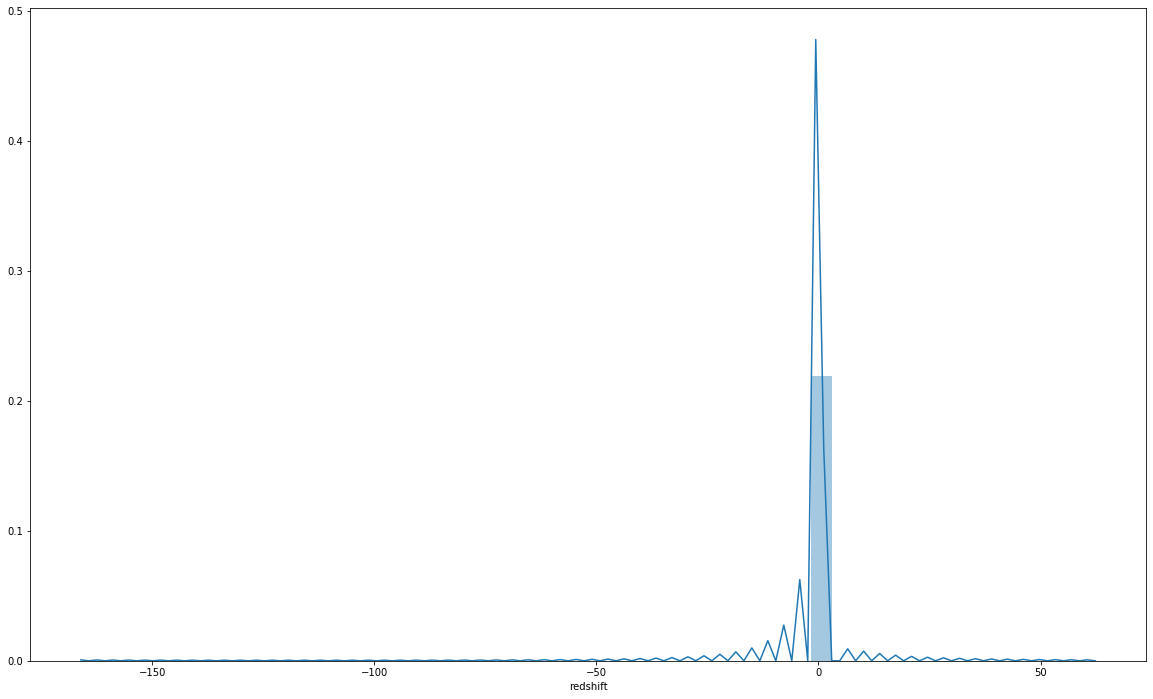

In [29]:
sns.distplot(train["redshift"])

In [30]:
# binn_shift = pd.qcut(train["redshift"], 50, labels = False)
# binn_shift

# alldata["binn_shift"] = binn_shift
# alldata



In [31]:
# alldata["u"] = alldata["u"]+17.7
# alldata["g"] = alldata["g"]+52
# alldata["r"] = alldata["r"]+5.5
# alldata["z"] = alldata["z"]+39.6

# alldata[["u","g","r","i","z"]] = alldata[["u","g","r","i","z"]].apply(np.log1p)
# alldata

In [32]:
alldata2 = alldata.drop(["id","class","airmass_u","airmass_g","airmass_r","airmass_i","airmass_z"], axis=1)
# alldata2 = alldata2.drop(["u","g","r","i","z"], axis=1)

alldata2

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,u-g,g-r,r-i,i-z,dered_diff1,dered_diff2,dered_diff3,dered_diff4,new,minusOD,plusOD,diff_u,diff_g,diff_r,diff_i,diff1,diff2,diff3,diff4,diff
0,23.263956,20.336773,19.009500,17.672439,16.939607,-0.000081,23.12426,20.25779,18.95512,17.63211,16.90894,18,18,2.927183,1.327273,1.337061,0.732833,2.86647,1.30267,1.32301,0.72317,6.324349,0,36,0.060713,0.024603,0.014051,0.009663,3.006166,1.381653,1.377390,0.040329,0.030667
1,15.052147,14.061969,13.452418,13.268450,13.168941,0.004506,14.96642,14.00452,13.41139,13.23625,13.13468,1,1,0.990179,0.609551,0.183968,0.099509,0.96190,0.59313,0.17514,0.10157,1.883207,0,2,0.028279,0.016421,0.008828,-0.002061,1.047627,0.650579,0.216168,0.032200,0.034261
2,16.786385,15.825426,15.536318,15.393535,15.350032,0.000472,16.60765,15.68659,15.44004,15.32173,15.29608,2,2,0.960959,0.289108,0.142783,0.043503,0.92106,0.24655,0.11831,0.02565,1.436353,0,4,0.039899,0.042558,0.024473,0.017853,1.099795,0.385386,0.214588,0.071805,0.053952
3,25.660638,21.188727,20.221158,19.894949,19.634649,0.000006,25.35365,20.99465,20.08727,19.79465,19.55518,4,3,4.471910,0.967569,0.326209,0.260300,4.35900,0.90738,0.29262,0.23947,6.025989,1,7,0.112910,0.060189,0.033589,0.020830,4.665988,1.101457,0.426508,0.100299,0.079469
4,24.453429,20.699170,19.042368,18.324152,17.982649,-0.000033,23.77140,20.43384,18.86299,18.19028,17.87592,13,12,3.754259,1.656803,0.718216,0.341503,3.33756,1.57085,0.67271,0.31436,6.470780,1,25,0.416699,0.085953,0.045506,0.027143,4.019589,1.836180,0.852088,0.133872,0.106729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,19.673388,18.661662,18.270788,18.122501,18.062672,-0.000317,19.33614,18.39331,18.08600,17.98610,17.96699,17,17,1.011727,0.390873,0.148287,0.059829,0.94283,0.30731,0.09990,0.01911,1.610717,0,34,0.068897,0.083563,0.048387,0.040719,1.280078,0.575662,0.284688,0.136401,0.095682
79996,21.522869,20.728282,20.608695,21.004875,20.845799,0.065455,21.39935,20.63992,20.54506,20.95069,20.78268,8,4,0.794588,0.119586,-0.396179,0.159076,0.75943,0.09486,-0.40563,0.16801,0.677070,4,12,0.035158,0.024726,0.009451,-0.008934,0.882949,0.183222,-0.341995,0.054185,0.063119
79997,19.399065,18.241076,18.160492,18.197753,18.201831,-0.000842,18.91359,17.87533,17.90469,18.00426,18.04000,1,1,1.157989,0.080584,-0.037262,-0.004078,1.03826,-0.02936,-0.09957,-0.03574,1.197234,0,2,0.119729,0.109944,0.062308,0.031662,1.523735,0.336386,0.156232,0.193493,0.161831
79998,18.899747,17.600868,17.132878,16.822347,16.594561,0.042817,18.77153,17.48798,17.05567,16.76595,16.55850,17,17,1.298879,0.467991,0.310531,0.227785,1.28355,0.43231,0.28972,0.20745,2.305186,0,34,0.015329,0.035681,0.020811,0.020335,1.411767,0.545198,0.366928,0.056397,0.036061


In [33]:
train2 = alldata2[:len(train)]
test2 = alldata2[len(train):]

In [34]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score

# x_train,x_valid, y_train, y_valid = train_test_split(train2, train["class"], test_size = 0.2, random_state = 42, shuffle = True,stratify = train["class"])

# hr2_accuracy_list = []

# max_depth_list = [195,200,205]
# # subsample_list = [0.6,0.7,0.8,0.9,1.0]

# def hr2_grid_search(max_depth): 
#     xgb_model = LGBMClassifier(n_estimators = 250, num_leaves=max_depth, n_jobs = -1)
#     xgb_pred = xgb_model.fit(x_train, y_train).predict(x_valid)
#     return([max_depth, accuracy_score(y_valid, xgb_pred)])
      

# for max_depth in max_depth_list:
#     hr2_accuracy_list.append(hr2_grid_search(max_depth))
    

# hr2_xgb_df = pd.DataFrame(hr2_accuracy_list, columns=['tree depth', 'accuracy'])
# print("accuracy max : "+str(hr2_xgb_df["accuracy"].argmax())+"행") 
# print(hr2_xgb_df)

In [35]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# alldata2 = ss.fit_transform(alldataa2)


In [51]:
## randomforest모델
# rf = RandomForestClassifier(n_estimators = 400)
# rf.fit(train2,train["class"])
# rf_result = rf.predict_proba(test2)

# rf_df = pd.DataFrame(rf_result)
# rf_df.columns = ["rf1","rf2","rf3"]
# rf_df.to_csv("rf_result.csv", index = False)


## catboost모델
# ca = CatBoostClassifier(n_estimators = 2000)
# ca.fit(x_train,y_train, eval_set = (x_valid, y_valid), early_stopping_rounds = 30)


x_train, x_valid, y_train, y_valid = train_test_split(train2,train["class"], 
                                                      test_size = 0.2, 
                                                      random_state = 42, 
                                                      shuffle = True, 
                                                      stratify = train["class"])

# lgb모델
# 1554 = n_estimators = 1500, num_leaves = 200, n_jobs = -1, learning_rate = 0.01
# lgb = LGBMClassifier(n_estimators = 300, num_leaves = 200, n_jobs = -1)
# lgb.fit(x_train,y_train, eval_set = (x_valid, y_valid), early_stopping_rounds = 100)


lgb = LGBMClassifier(objective='multiclass',
                     n_estimators = 1000, 
                     num_leaves=200,
                     learning_rate=0.1,
                     n_jobs = -1, 
                     min_child_samples = 10, 
                     colsample_bytree = 0.7,
                     random_state=42,
                     subsample = 0.8, 
                     subsample_freq = 1)


lgb.fit(x_train,y_train, eval_set = (x_valid, y_valid), eval_metric="multiclass" ,early_stopping_rounds = 150)
result = lgb.predict_proba(test2)

p_val = lgb.predict(x_valid)
p_tst = lgb.predict(test2)
# 200 0.1557 -> 0.1554

# 0.1570 Base


[1]	valid_0's multi_logloss: 0.874807
Training until validation scores don't improve for 150 rounds
[2]	valid_0's multi_logloss: 0.788005
[3]	valid_0's multi_logloss: 0.7129
[4]	valid_0's multi_logloss: 0.650024
[5]	valid_0's multi_logloss: 0.598149
[6]	valid_0's multi_logloss: 0.554816
[7]	valid_0's multi_logloss: 0.518145
[8]	valid_0's multi_logloss: 0.484976
[9]	valid_0's multi_logloss: 0.451329
[10]	valid_0's multi_logloss: 0.423883
[11]	valid_0's multi_logloss: 0.398111
[12]	valid_0's multi_logloss: 0.376419
[13]	valid_0's multi_logloss: 0.358355
[14]	valid_0's multi_logloss: 0.342221
[15]	valid_0's multi_logloss: 0.328221
[16]	valid_0's multi_logloss: 0.313901
[17]	valid_0's multi_logloss: 0.302144
[18]	valid_0's multi_logloss: 0.289878
[19]	valid_0's multi_logloss: 0.279323
[20]	valid_0's multi_logloss: 0.268548
[21]	valid_0's multi_logloss: 0.261279
[22]	valid_0's multi_logloss: 0.253282
[23]	valid_0's multi_logloss: 0.244688
[24]	valid_0's multi_logloss: 0.237313
[25]	valid_0'

[208]	valid_0's multi_logloss: 0.157447
[209]	valid_0's multi_logloss: 0.157502
[210]	valid_0's multi_logloss: 0.157512
[211]	valid_0's multi_logloss: 0.157534
[212]	valid_0's multi_logloss: 0.157591
[213]	valid_0's multi_logloss: 0.157609
[214]	valid_0's multi_logloss: 0.157633
[215]	valid_0's multi_logloss: 0.157651
[216]	valid_0's multi_logloss: 0.157679
[217]	valid_0's multi_logloss: 0.157711
[218]	valid_0's multi_logloss: 0.157726
[219]	valid_0's multi_logloss: 0.157726
[220]	valid_0's multi_logloss: 0.157738
[221]	valid_0's multi_logloss: 0.157762
[222]	valid_0's multi_logloss: 0.157799
[223]	valid_0's multi_logloss: 0.157824
[224]	valid_0's multi_logloss: 0.157839
[225]	valid_0's multi_logloss: 0.157882
[226]	valid_0's multi_logloss: 0.157918
[227]	valid_0's multi_logloss: 0.157942
[228]	valid_0's multi_logloss: 0.157961
[229]	valid_0's multi_logloss: 0.158
[230]	valid_0's multi_logloss: 0.158029
[231]	valid_0's multi_logloss: 0.158046
[232]	valid_0's multi_logloss: 0.158106
[23

In [52]:
print(f'{accuracy_score(y_valid, p_val) * 100:.4f}%')

93.5359%


In [53]:
# #####  Kfold 제출용 
# sfk = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
# result = 0

# for i,j in sfk.split(train2,train["class"]):
#     x_train = train2.iloc[i]
#     x_valid = train2.iloc[j]
#     y_train = train["class"].iloc[i]
#     y_valid = train["class"].iloc[j]

#     lgb = LGBMClassifier(n_estimators = 300, num_leaves = 200, n_jobs = -1)
#     lgb.fit(x_train,y_train, eval_set = (x_valid, y_valid), early_stopping_rounds = 150)
#     result += lgb.predict_proba(test2)/10
    
# lgb_result = pd.DataFrame(result)
# lgb_result.columns = ["lgb1","lgb2","lgb3"]
# lgb_result.to_csv("lgb_result.csv", index = False)



In [54]:
# print(accuracy_score(np.array(y_valid).astype(int),result.argmax(1)))
# confusion_matrix(np.array(y_valid).astype(int),result.argmax(1)) 

In [55]:
sub = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\sample_submission.csv")
sub

,id,class
0,320000,0
1,320001,0
2,320002,0
3,320003,0
4,320004,0
...,...,...
79995,399995,0
79996,399996,0
79997,399997,0
79998,399998,0


In [56]:
sub["class"] = result.argmax(1)
sub

,id,class
0,320000,2
1,320001,0
2,320002,2
3,320003,0
4,320004,2
...,...,...
79995,399995,0
79996,399996,2
79997,399997,0
79998,399998,2


In [61]:
sub.to_csv("lightgbm과제.csv", index=False)

In [62]:
pd.Series(lgb.feature_importances_, index = train2.columns).sort_values(ascending = False).reset_index()

,index,0
0,redshift,4749
1,dered_diff3,4137
2,dered_diff2,3697
3,g-r,3369
4,r-i,3354
5,dered_diff4,3264
6,i-z,3139
7,dered_diff1,3054
8,diff2,2549
9,u-g,2507
